# Notebook for analyzing Illumina sequencing of clones from T4CGAp5 evolution experiment
written by Sri Srikant, plan to move to llc2.mit.edu for remote analysis of genome sequencing.
[210731] Intiating the notebook

In [1]:
##Libaries and packages used in this notebook. Version information recorded where appropriate.
import os
import sys
import shutil
import glob
import subprocess

import traceback
import re
import collections

import Bio
from Bio import SeqIO
import xml.etree.ElementTree as ET

import csv
import pandas as pd

from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

##Set pdf ouput of matplotlib to have embedded fonts that are editable in Illustrator
plt.rcParams['pdf.fonttype'] = 42

#Directories
home_dir = os.path.join("/home", "ssrikant")
data_dir = os.path.join(home_dir, "WindowsFiles", "postdoc_data")
illumina_data_dir = os.path.join(data_dir, "Sequencing")
print("List of directories of Illumina sequencing:")
print("\n".join([d for d in os.listdir(illumina_data_dir) if os.path.isdir(os.path.join(illumina_data_dir, d))]))

#Binary commands
fastqc_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/fastqc"
cutadapt_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/cutadapt"
bwa_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/bwa"
samtools_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/samtools"
varscan_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/varscan"
gatk_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/gatk3"
bcftools_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/bcftools"
vcfutils_cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/vcfutils.pl"

List of directories of Illumina sequencing:
20201009_Phage-gDNA_Lib01_T4Ap2_MiSeq_201007
20201029_Phage-gDNA_Lib02_T4CGAp5_NextSeq_201024
20201111_Phage-gDNA_Lib03_T4CGAp5_NextSeq_201110
20201029_Phage-gDNA_Lib02_T4Ap2_NextSeq_201024
20201118_Phage-gDNA_Nanopore_201116
20201119_Phage-gDNA_Lib04_T4Ap2_MiSeq-v2_201117
20201214_Phage-gDNA_Lib05_T4Ap2-Ap5-pop_NextSeq_201209
20210310_Phage-gDNA_Lib06_Phage03-T4Ap7_MiSeq_210311
20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313
20210322_Phage-gDNA_Lib08_PacBio_210318
20210504_Phage-gDNA_Lib09_RB69Ap1-2_MiSeq_210503
20210527_Phage-gDNA_Lib10_T4CGAp5_PromethION_210526
20220131_Ecoli-gDNA_Lib11_ec084-ECOR17-71_220128
20220208_Phage-gDNA_Lib12_LS50-phage_NextSeq_220201


## Sequencing read evaluation and clean-up
1. Script to go through fastq.gz files and scan each read for sequences homologous to the adaptors and barcode primer regions that are used in library construction. (Copied from what I wrote on LLC2)
    1. [201231] I am looking for a pre-written program and I found cutadapt (https://cutadapt.readthedocs.io/en/stable/ WITH https://pypi.org/project/cutadapt/).
    2. The adaptor sequencing used for us is listed below.
    3. I am going to setup the cutadapt by iterating through all folders of demultiplexed samples in an experiment directory.
2. Running the bwa aligner on the cutadapted reads using the T4 reference genome.
    1. Reference genome choice is either T4CGAp5pAnc or T4_NC_000866p4 both of which have been exported as .fasta and .gb files from Geneious.
    2. I am going to output the aligned files into a bwa output folder.
    3. Keep in mind that the intermediate files (sai, bam, sam) are all very large and I think I should set this up to not delete the intermediates once a downstream step is completed.

In [2]:
##Identifying adaptor sequences as they show up in the reads. Important that the BMC and Laub lab use the forked ('Y') adapters and barcoded adapters from Illumina's PE kit that leads
##to a final read containing the insert flanked by the barcoding primer sequences adjacent to the insert.
#Complement sequence of that in 2.x barcoding primers.
adaptor_fwd_read_1 = Bio.Seq.Seq("AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCG")
#Sequence of that in 1.x barcoding primers.
adaptor5seq_rev_read_2 = Bio.Seq.Seq("ACACTCTTTCCCTACACGACGCTCTTCCGATCT").reverse_complement()
#print(adaptor5seq_rev_read_2)

#Print sequence that is found in the barcoding primer
print("\t".join(["1.x:", str(adaptor_fwd_read_1.reverse_complement())]))
print("\t".join(["2.x:", str(adaptor5seq_rev_read_2.reverse_complement())]))

1.x:	CGGTCTCGGCATTCCTGCTGAACCGCTCTTCCGATCT
2.x:	ACACTCTTTCCCTACACGACGCTCTTCCGATCT


In [3]:
##Output file list to a csv file, and then make the file list for all analysis.
analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313", "bmc_raw")

##Loop through fastq files in parent directory.
print("\t".join(["Working in folder:", os.path.join(analysis_working_dir)]))
#file_list = [i for i in os.listdir(os.path.join(analysis_working_dir)) if i.endswith(".fastq.gz")]
file_list = ["_".join(i.split("_")[:2]) for i in os.listdir(os.path.join(analysis_working_dir)) if i.endswith(".fastq.gz")]
#print(file_list)

file_list_frame = pd.DataFrame(file_list).drop_duplicates()
print(file_list_frame)

output_filelist = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313", "T4Ap5_Lib07-illumina-filelist.csv")
file_list_frame.to_csv(output_filelist, header=False, index=False)

Working in folder:	/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_raw
                     0
0   210317Lau_D21-2631
2   210317Lau_D21-2632
4   210317Lau_D21-2633
6   210317Lau_D21-2634
8   210317Lau_D21-2635
10  210317Lau_D21-2636


In [6]:
##Running FastQC on the raw fastq.gz files from BMC to get a sense of the quality of reads.
analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313", "bmc_raw")

input_filelist = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313", "T4Ap5_Lib07-illumina-filelist.csv")
#illumina_filelist = pd.read_csv(input_filelist, header=None)
illumina_filelist = []
with open(input_filelist, 'r') as file_handle:
    fileread = csv.reader(file_handle)
    for row in fileread:
        illumina_filelist.extend(row)
print(illumina_filelist)

fastqc_output_dir = os.path.join("/".join(analysis_working_dir.split("/")[:-1]), "bmc_fastqc")
#print(cutadapt_output_dir)
if not(os.path.isdir(fastqc_output_dir)):
    os.mkdir(fastqc_output_dir)
    
logfile_dir = os.path.join("/".join(analysis_working_dir.split("/")[:-1]), "logfile")
#print(cutadapt_output_dir)
if not(os.path.isdir(logfile_dir)):
    os.mkdir(logfile_dir)
if not(os.path.isdir(os.path.join(logfile_dir, "fastqc"))):
    os.mkdir(os.path.join(logfile_dir, "fastqc"))
    
##Loop through fastq files in analysis directory using the illumina filelist.
print("\t".join(["Working in folder:", os.path.join(analysis_working_dir)]))
for illumina_file in illumina_filelist:
    print("\t".join(["Running FastQC to check quality of reads from sample:", illumina_file])) 
    print("\n".join(["FastQC reports saved to:", fastqc_output_dir]))
    stdout_file = os.path.join(logfile_dir, "fastqc", illumina_file+"_fastqc.out")
    fastqc_run = [fastqc_cmd, "-o", fastqc_output_dir, "-t", "2", 
                    os.path.join(analysis_working_dir, illumina_file+"_1_sequence.fastq.gz"), os.path.join(analysis_working_dir, illumina_file+"_2_sequence.fastq.gz")]
    #print(cutadapt_run)
    result = subprocess.run(fastqc_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'w') as f:
        print(result.stdout, file=f)

['210317Lau_D21-2631', '210317Lau_D21-2632', '210317Lau_D21-2633', '210317Lau_D21-2634', '210317Lau_D21-2635', '210317Lau_D21-2636']
Working in folder:	/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_raw
Running FastQC to check quality of reads from sample:	210317Lau_D21-2631
FastQC reports saved to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_fastqc


Started analysis of 210317Lau_D21-2631_1_sequence.fastq.gz
Started analysis of 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2631_1_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2631_2_sequence.fastq.gz
Ap

Running FastQC to check quality of reads from sample:	210317Lau_D21-2632
FastQC reports saved to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_fastqc


Started analysis of 210317Lau_D21-2632_1_sequence.fastq.gz
Started analysis of 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2632_1_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2632_2_sequence.fastq.gz
Ap

Running FastQC to check quality of reads from sample:	210317Lau_D21-2633
FastQC reports saved to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_fastqc


Started analysis of 210317Lau_D21-2633_1_sequence.fastq.gz
Started analysis of 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2633_1_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2633_2_sequence.fastq.gz
Ap

Running FastQC to check quality of reads from sample:	210317Lau_D21-2634
FastQC reports saved to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_fastqc


Started analysis of 210317Lau_D21-2634_1_sequence.fastq.gz
Started analysis of 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2634_1_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2634_2_sequence.fastq.gz
Ap

Running FastQC to check quality of reads from sample:	210317Lau_D21-2635
FastQC reports saved to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_fastqc


Started analysis of 210317Lau_D21-2635_1_sequence.fastq.gz
Started analysis of 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2635_1_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2635_2_sequence.fastq.gz
Ap

Running FastQC to check quality of reads from sample:	210317Lau_D21-2636
FastQC reports saved to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_fastqc


Started analysis of 210317Lau_D21-2636_1_sequence.fastq.gz
Started analysis of 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 5% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 10% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 15% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 20% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 25% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 30% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2636_1_sequence.fastq.gz
Approx 35% complete for 210317Lau_D21-2636_2_sequence.fastq.gz
Ap

In [7]:
##I tested cutadpt run in the terminal to remove the adapters and it seems to be working appropriately. This is for paired-end reads. 
##command: cutadapt -a AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCG -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o test_1.fastq.gz -p test_2.fastq.gz 201123Lau_D20-283001_1_sequence.fastq.gz 201123Lau_D20-283001_2_sequence.fastq.gz
#I am going to write this in as a piece of code that loops through folders and looks for the fasta.gz files similar to the gzipping code cell above.
#Adding a minimum-length cut-off since bwa downstream seems to get thrown off by aligning empty reads in the paired samples differently.
analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313", "bmc_raw")

input_filelist = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313", "T4Ap5_Lib07-illumina-filelist.csv")
#illumina_filelist = pd.read_csv(input_filelist, header=None)
illumina_filelist = []
with open(input_filelist, 'r') as file_handle:
    fileread = csv.reader(file_handle)
    for row in fileread:
        illumina_filelist.extend(row)
print(illumina_filelist)
#sys.exit()

cutadapt_output_dir = os.path.join("/".join(analysis_working_dir.split("/")[:-1]), "bmc_cutadapt")
#print(cutadapt_output_dir)
if not(os.path.isdir(cutadapt_output_dir)):
    os.mkdir(cutadapt_output_dir)
    
logfile_dir = os.path.join("/".join(analysis_working_dir.split("/")[:-1]), "logfile")
#print(cutadapt_output_dir)
if not(os.path.isdir(logfile_dir)):
    os.mkdir(logfile_dir)
if not(os.path.isdir(os.path.join(logfile_dir, "cutadapt"))):
    os.mkdir(os.path.join(logfile_dir, "cutadapt"))

##Loop through fastq files in analysis directory using the illumina filelist.
print("\t".join(["Working in folder:", os.path.join(analysis_working_dir)]))
for illumina_file in illumina_filelist:
    print("\t".join(["Trimming adaptors from paired-end reads of:", illumina_file])) 
    #output_files are going to be modifications of the input files "*.fasta.gz" -> "*.cutadapt.fasta.gz"
    output_fwd_read = os.path.join(cutadapt_output_dir, illumina_file+"_1_sequence.fastq.gz").split("fastq.gz")[0]+"cutadapt.fastq.gz"
    output_rev_read = os.path.join(cutadapt_output_dir, illumina_file+"_2_sequence.fastq.gz").split("fastq.gz")[0]+"cutadapt.fastq.gz"
    print("\n".join(["Trimmed reads saved in-place to:", output_fwd_read, output_rev_read]))
    stdout_file = os.path.join(logfile_dir, "cutadapt", illumina_file+"_cutadapt.out")
    cutadapt_run = [cutadapt_cmd, "--minimum-length", "20", 
                    "-a", str(adaptor_fwd_read_1), "-A", str(adaptor5seq_rev_read_2), 
                    "-o", output_fwd_read, "-p", output_rev_read, 
                    os.path.join(analysis_working_dir, illumina_file+"_1_sequence.fastq.gz"), os.path.join(analysis_working_dir, illumina_file+"_2_sequence.fastq.gz")]
    #print(cutadapt_run)
    result = subprocess.run(cutadapt_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'w') as f:
        print(result.stdout, file=f)

['210317Lau_D21-2631', '210317Lau_D21-2632', '210317Lau_D21-2633', '210317Lau_D21-2634', '210317Lau_D21-2635', '210317Lau_D21-2636']
Working in folder:	/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_raw
Trimming adaptors from paired-end reads of:	210317Lau_D21-2631
Trimmed reads saved in-place to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2631_1_sequence.cutadapt.fastq.gz
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2631_2_sequence.cutadapt.fastq.gz
Trimming adaptors from paired-end reads of:	210317Lau_D21-2632
Trimmed reads saved in-place to:
/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2632_1_sequence.cutadapt.fastq.gz
/home/ssrikant/WindowsFiles/postdoc_data/Sequenci

In [2]:
##Defining the working directory.
analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")

##Importing the csv that has all the details to run the alignments.
raw_sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
raw_sample_list

,SampleName,FileName,Reference,PlottingReference
0,T4CGAp5pAnc,NaN,NaN,T4CGAp5pAnc_consensus
1,T4CGAp5p25p00p01,210317Lau_D21-2631,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
2,T4CGAp5p25p01p01,210317Lau_D21-2632,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
3,T4CGAp5p25p02p01,210317Lau_D21-2633,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
4,T4CGAp5p25p03p01,210317Lau_D21-2634,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
5,T4CGAp5p25p04p01,210317Lau_D21-2635,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
6,T4CGAp5p25p05p03,210317Lau_D21-2636,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus


### Completed QC and pre-processing of raw reads from BMC
1. Ran FastQC on the raw reads from BMC and it looks like there are some adapter sequences that I am not accounting for.
    1. Look like there are the following over-represented sequences from the library of Illumina paired adapters: Illumina Paired End PCR Primer 2 (CGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGCGTTATA), Illumina Paired End Adapter 2 (GATCGGAAGAGCGGTTCAGCAG), Illumina Paired End Adapter 2 (CGGAAGAGCGGTTCAGCAG), Illumina Single End PCR Primer 1 (CACTCTTTCCCTACACGACGCTCTTCCGAT)
    2. This is the worst in the 'T4CG_cloneA' sample, but I most seem comparable.
    3. On the other hand the read quality is amazing so I think this should be good enough for assembly to a reference genome.
2. I ran cutadapt on the ".fastq.gz" paired-end files and have generated the files I am going to use for subsequnt alignment to reference genome.
    1. Ran cutadapt with the adapters being parts of the sequence from the 1.x and 2.x barcoing primers of the MIT BMC/Laub lab.

## Running bwa to align reads and samtools to process the alignments.
1. First index the reference genomes needed (as listed in the sample list) using bwa index.
    1. Setup using subprocess, and have to use shutil.move() to move the relevant files from the pwd of the jupyter notebook in WSL to the folder containing the sequencing reads.
    2. Generates 5 files per genome, and am also giving them the label of the reference genome name.
2. Running bwa aln for each of the fwd and rev read files and then bwa sampe to combine the files to a single bam file.
    1. I got an error that suggests empty reads (generated from cutadapt to remove adapter containing reads) leads to what look like mis-matched alignments when using the the bwa aln with separate read files. I modified the cutadapt above to filter for reads that have 20bp of non-adapter sequence and this fixed the issue.
    2. The sam files are huge and I am going write in a deletion of the intermediate files once the final sorted bam file and the variant called files are generated.
3. Running samtools to obtain the indexed, sorted bam file.
    1. Running samtools view to convert {.sam} ASCII file to {.bam} binary file.
    2. Running samtools sort to sort {.bam} file by the position in the reference genome.
    3. Running samtools index to index the {.sorted.bam} file for further analysis.
    4. Running samtools flagstat to obtain alignment statistics by bwa and output to a {.stats} file of all samples in the Illumina run.
4. Cleaning up intermediate files to save disk space.
    1. Specifically need to clean up the initial alignments {.sai}, ASCII {.sam}, and binary {.bam} files.

In [11]:
##Running bwa to index the reference genomes that are needed in this set of samples.
##Using the bwa index algorithm 'is' since all phage genomes are small.
# analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")
# sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
#Defined above centrally.
sample_list = raw_sample_list.dropna(subset=['Reference'])

reference_genomes_dir = os.path.join(analysis_working_dir, "refgenomes")
refgenome_list = sample_list['Reference'].unique()
#print(refgenome_list)

logfile_dir = os.path.join(analysis_working_dir, "logfile")
#print(cutadapt_output_dir)
if not(os.path.isdir(logfile_dir)):
    os.mkdir(logfile_dir)
if not(os.path.isdir(os.path.join(logfile_dir, "bwa"))):
    os.mkdir(os.path.join(logfile_dir, "bwa"))

for refgenome in refgenome_list:
    print("\t".join(["Indexing reference genome:", os.path.join(reference_genomes_dir, refgenome+".fasta")]))
    print("\t".join(["Indexed genomes saved in-place to:", reference_genomes_dir]))
    stdout_file = os.path.join(logfile_dir, "bwa", refgenome+"_bwa-index.out")
    bwa_run = [bwa_cmd, "index", "-a", "is", "-p", refgenome,
              os.path.join(reference_genomes_dir, refgenome+".fasta")]
    #print(cutadapt_run)
    result = subprocess.run(bwa_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'w') as f:
        print(result.stdout, file=f)
    
    #Move files that are generated to the refgenome folder.
    for file in glob.glob(refgenome+'.*'):
        shutil.move(file, reference_genomes_dir)        

Indexing reference genome:	/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus.fasta
Indexed genomes saved in-place to:	/home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes


[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.03 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.02 sec
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa index -a is -p T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus.fasta
[main] Real time: 0.162 sec; CPU: 0.064 sec


PermissionError: [Errno 1] Operation not permitted

In [12]:
##Running bwa aligner to align the cutadapted reads to the relevant reference genome.
# analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")
# sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
#Defined above centrally.
sample_list = raw_sample_list.dropna(subset=['Reference'])

cutadapt_illumina_dir = os.path.join(analysis_working_dir, "bmc_cutadapt")
reference_genomes_dir = os.path.join(analysis_working_dir, "refgenomes")

bwa_output_dir = os.path.join(analysis_working_dir, "bwa")
if not(os.path.isdir(bwa_output_dir)):
    os.mkdir(bwa_output_dir)
    
logfile_dir = os.path.join(analysis_working_dir, "logfile")
#print(cutadapt_output_dir)
if not(os.path.isdir(logfile_dir)):
    os.mkdir(logfile_dir)
if not(os.path.isdir(os.path.join(logfile_dir, "bwa"))):
    os.mkdir(os.path.join(logfile_dir, "bwa"))
    
for sample in sample_list['SampleName']:
    print("\t".join(["Working on aligning reads for sample:", sample]))
    ref_genome = sample_list[sample_list['SampleName'] == sample].iloc[0]['Reference']
    sample_filename = sample_list[sample_list['SampleName'] == sample].iloc[0]['FileName']
    stdout_file = os.path.join(logfile_dir, "bwa", ref_genome+"_bwa.out")
    
    ##Aligning fwd reads to genome.
    with open(os.path.join(bwa_output_dir, sample+"_1.sai"), "w") as output_handle:
        bwa_run = [bwa_cmd, "aln", os.path.join(reference_genomes_dir, ref_genome), 
                   os.path.join(cutadapt_illumina_dir, sample_filename+"_1_sequence.cutadapt.fastq.gz")]
        #print(bwa_run)
        result = subprocess.run(bwa_run, stdout=output_handle)

    ##Aligning rev reads to genome.
    with open(os.path.join(bwa_output_dir, sample+"_2.sai"), "w") as output_handle:
        bwa_run = [bwa_cmd, "aln", os.path.join(reference_genomes_dir, ref_genome), 
                   os.path.join(cutadapt_illumina_dir, sample_filename+"_2_sequence.cutadapt.fastq.gz")]
        #print(bwa_run)
        result = subprocess.run(bwa_run, stdout=output_handle)
        
    ##Pooling alignments into a sam file.
    with open(os.path.join(bwa_output_dir, sample+"_bwa.sam"), "w") as output_handle:
        bwa_run = [bwa_cmd, "sampe", os.path.join(reference_genomes_dir, ref_genome),
                   os.path.join(bwa_output_dir, sample+"_1.sai"), os.path.join(bwa_output_dir, sample+"_2.sai"),
                   os.path.join(cutadapt_illumina_dir, sample_filename+"_1_sequence.cutadapt.fastq.gz"), os.path.join(cutadapt_illumina_dir, sample_filename+"_2_sequence.cutadapt.fastq.gz"),
                   ]
        #print(bwa_run)
        result = subprocess.run(bwa_run, stdout=output_handle)

Working on aligning reads for sample:	T4CGAp5p25p00p01


[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: max_diff = 5
[bwa_aln] 124bp reads: max_diff = 6
[bwa_aln] 157bp reads: max_diff = 7
[bwa_aln] 190bp reads: max_diff = 8
[bwa_aln] 225bp reads: max_diff = 9
[bwa_aln_core] calculate SA coordinate... 3.06 sec
[bwa_aln_core] write to the disk... 0.23 sec
[bwa_aln_core] 152933 sequences have been processed.
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa aln /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2631_1_sequence.cutadapt.fastq.gz
[main] Real time: 6.185 sec; CPU: 3.673 sec
[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: m

Working on aligning reads for sample:	T4CGAp5p25p01p01


[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: max_diff = 5
[bwa_aln] 124bp reads: max_diff = 6
[bwa_aln] 157bp reads: max_diff = 7
[bwa_aln] 190bp reads: max_diff = 8
[bwa_aln] 225bp reads: max_diff = 9
[bwa_aln_core] calculate SA coordinate... 3.90 sec
[bwa_aln_core] write to the disk... 0.19 sec
[bwa_aln_core] 135224 sequences have been processed.
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa aln /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2632_1_sequence.cutadapt.fastq.gz
[main] Real time: 6.533 sec; CPU: 4.459 sec
[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: m

Working on aligning reads for sample:	T4CGAp5p25p02p01


[bwa_aln_core] calculate SA coordinate... 4.23 sec
[bwa_aln_core] write to the disk... 0.28 sec
[bwa_aln_core] 185397 sequences have been processed.
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa aln /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2633_1_sequence.cutadapt.fastq.gz
[main] Real time: 7.848 sec; CPU: 4.923 sec
[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: max_diff = 5
[bwa_aln] 124bp reads: max_diff = 6
[bwa_aln] 157bp reads: max_diff = 7
[bwa_aln] 190bp reads: max_diff = 8
[bwa_aln] 225bp reads: max_diff = 9
[bwa_aln_core] calculate SA coordinate... 3.89 sec
[bwa_aln_core] write to the disk... 0.30 sec
[bwa_aln_core] 185397 sequences 

Working on aligning reads for sample:	T4CGAp5p25p03p01


[bwa_aln_core] calculate SA coordinate... 4.21 sec
[bwa_aln_core] write to the disk... 0.23 sec
[bwa_aln_core] 156462 sequences have been processed.
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa aln /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2634_1_sequence.cutadapt.fastq.gz
[main] Real time: 7.270 sec; CPU: 4.839 sec
[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: max_diff = 5
[bwa_aln] 124bp reads: max_diff = 6
[bwa_aln] 157bp reads: max_diff = 7
[bwa_aln] 190bp reads: max_diff = 8
[bwa_aln] 225bp reads: max_diff = 9
[bwa_aln_core] calculate SA coordinate... 3.75 sec
[bwa_aln_core] write to the disk... 0.23 sec
[bwa_aln_core] 156462 sequences 

Working on aligning reads for sample:	T4CGAp5p25p04p01


[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: max_diff = 5
[bwa_aln] 124bp reads: max_diff = 6
[bwa_aln] 157bp reads: max_diff = 7
[bwa_aln] 190bp reads: max_diff = 8
[bwa_aln] 225bp reads: max_diff = 9
[bwa_aln_core] calculate SA coordinate... 4.24 sec
[bwa_aln_core] write to the disk... 0.24 sec
[bwa_aln_core] 126231 sequences have been processed.
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa aln /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2635_1_sequence.cutadapt.fastq.gz
[main] Real time: 7.485 sec; CPU: 4.976 sec
[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: m

Working on aligning reads for sample:	T4CGAp5p25p05p03


[bwa_aln_core] calculate SA coordinate... 4.04 sec
[bwa_aln_core] write to the disk... 0.28 sec
[bwa_aln_core] 161999 sequences have been processed.
[main] Version: 0.7.17-r1188
[main] CMD: /home/ssrikant/anaconda3/envs/bio-conda/bin/bwa aln /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/refgenomes/T4CGAp5pAnc_consensus /home/ssrikant/WindowsFiles/postdoc_data/Sequencing/20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313/bmc_cutadapt/210317Lau_D21-2636_1_sequence.cutadapt.fastq.gz
[main] Real time: 7.552 sec; CPU: 4.745 sec
[bwa_aln] 17bp reads: max_diff = 2
[bwa_aln] 38bp reads: max_diff = 3
[bwa_aln] 64bp reads: max_diff = 4
[bwa_aln] 93bp reads: max_diff = 5
[bwa_aln] 124bp reads: max_diff = 6
[bwa_aln] 157bp reads: max_diff = 7
[bwa_aln] 190bp reads: max_diff = 8
[bwa_aln] 225bp reads: max_diff = 9
[bwa_aln_core] calculate SA coordinate... 3.82 sec
[bwa_aln_core] write to the disk... 0.29 sec
[bwa_aln_core] 161999 sequences 

In [13]:
##Converting sam files in 'bwa' folder to bam files. Generating sorted bam file, and index sorted bam file.
# analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")
# sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
#Defined above centrally.
sample_list = raw_sample_list.dropna(subset=['Reference'])

bwa_dir = os.path.join(analysis_working_dir, "bwa")
reference_genomes_dir = os.path.join(analysis_working_dir, "refgenomes")
    
logfile_dir = os.path.join(analysis_working_dir, "logfile")
#print(cutadapt_output_dir)
if not(os.path.isdir(logfile_dir)):
    os.mkdir(logfile_dir)
if not(os.path.isdir(os.path.join(logfile_dir, "bwa"))):
    os.mkdir(os.path.join(logfile_dir, "bwa"))
    
for sample in sample_list['SampleName']:
    print("\t".join(["Converting sam file to bam for:", sample]))
    stdout_file = os.path.join(logfile_dir, "bwa", sample+"_bwa.out")
    
    ##Converting sam file to bam file, with samtools view
    with open(os.path.join(bwa_dir, sample+"_bwa.bam"), "w") as output_handle:
        samtools_run = [samtools_cmd, "view", "-bS", os.path.join(bwa_dir, sample+"_bwa.sam")]
        #print(bwa_run)
        result = subprocess.run(samtools_run, stdout=output_handle)
        
    ##Sorting bam file to generate *.sorted.bam file.
    print("\t".join(["Sorting bam file for:", sample]))
    samtools_run = [samtools_cmd, "sort", "-O", "bam", "-o", os.path.join(bwa_dir, sample+"_bwa.sorted.bam"), os.path.join(bwa_dir, sample+"_bwa.bam")]
    #print(cutadapt_run)
    result = subprocess.run(samtools_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'a') as f:
        print("\nSorting bam file for:\t"+sample, file=f)
        print(result.stdout, file=f)
        
    ##Indexing *.sorted.bam file
    print("\t".join(["Indexing sorted bam file for:", sample]))
    samtools_run = [samtools_cmd, "index", os.path.join(bwa_dir, sample+"_bwa.sorted.bam")]
    #print(cutadapt_run)
    result = subprocess.run(samtools_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'a') as f:
        print("\nIndexng sorted bam file for:\t"+sample, file=f)
        print(result.stdout, file=f)
        
    ##Measuring alignment statistics using samtools flagstat.
    print("\t".join(["Evaluating alignment statistics of:", sample]))
    ref_genome = sample_list[sample_list['SampleName'] == sample].iloc[0]['Reference']
    flagstat_output_file = os.path.join(bwa_dir, analysis_working_dir.split("/")[-1]+"_bwa.stats")
    samtools_run = [samtools_cmd, "flagstat", os.path.join(bwa_dir, sample+"_bwa.bam")]
    #print(cutadapt_run)
    with open(flagstat_output_file, 'a') as output_handle:
        output_handle.write("\nAlignment statstics for "+sample+" against "+ref_genome+".\n")
        output_handle.flush()
        result = subprocess.run(samtools_run, stdout=output_handle)

Converting sam file to bam for:	T4CGAp5p25p00p01
Sorting bam file for:	T4CGAp5p25p00p01
Indexing sorted bam file for:	T4CGAp5p25p00p01
Evaluating alignment statistics of:	T4CGAp5p25p00p01
Converting sam file to bam for:	T4CGAp5p25p01p01
Sorting bam file for:	T4CGAp5p25p01p01
Indexing sorted bam file for:	T4CGAp5p25p01p01
Evaluating alignment statistics of:	T4CGAp5p25p01p01
Converting sam file to bam for:	T4CGAp5p25p02p01
Sorting bam file for:	T4CGAp5p25p02p01
Indexing sorted bam file for:	T4CGAp5p25p02p01
Evaluating alignment statistics of:	T4CGAp5p25p02p01
Converting sam file to bam for:	T4CGAp5p25p03p01
Sorting bam file for:	T4CGAp5p25p03p01
Indexing sorted bam file for:	T4CGAp5p25p03p01
Evaluating alignment statistics of:	T4CGAp5p25p03p01
Converting sam file to bam for:	T4CGAp5p25p04p01
Sorting bam file for:	T4CGAp5p25p04p01
Indexing sorted bam file for:	T4CGAp5p25p04p01
Evaluating alignment statistics of:	T4CGAp5p25p04p01
Converting sam file to bam for:	T4CGAp5p25p05p03
Sorting bam

In [ ]:
##Code cell to remove the intermediate files of the alignments of FASTA reads against reference genomes.
bwa_dir = os.path.join(analysis_working_dir, "bwa")
#Removing intermediate sai, sam and bam files. Only sorted.bam and sorted.bam.bai files for further work.
os.remove(os.path.join(bwa_dir, sample+"_1.sai"))
os.remove(os.path.join(bwa_dir, sample+"_2.sai"))
os.remove(os.path.join(bwa_dir, sample+"_bwa.sam"))
os.remove(os.path.join(bwa_dir, sample+"_bwa.bam"))
print("\n".join(["Intermediate alignment files have been removed:", 
                 os.path.join(bwa_dir, sample+"_1.sai"), os.path.join(bwa_dir, sample+"_2.sai"),
                 os.path.join(bwa_dir, sample+"_bwa.sam"), os.path.join(bwa_dir, sample+"_bwa.bam")]))

## Running samtools/bcftools to call variants and prepare coverage depth maps
1. Use samtools/mpileup to generate variant-calling file with the {.sorted.bam} file and the genome to which the Illumina reads were mapped.
    1. I am going to generate a new folder for "variants", to store all the result files.
> samtools mpileup -u -f ../refgenomes/T4_NC_000866p4.fasta -v -o test.vcf T4CGAp5pAnc_bwa.sorted.bam ##Build pileup file of bam alignment to call variants. vcf file can be compressed.
2. Use bcftools/call to call SNP varints.
    1. Using ploidy of 1 since phage genomes are always going to be haploid. Ploidy set to haploid since default is for diploid organisms.Ploidy set to haploid since default is for diploid organisms.
    2. I need to figure out how to include Indel calls in 
> bcftools call -O v -vc --ploidy 1 -o test-call.vcf test.vcf ##Call variant SNPs (not Indels) compared to reference and save to output vcf file, tabulated SNP file. 
3. Use samttols/depth to export the tab-separated file of coverage depth over reference-genome position.
    1. I am going to use the -aa option to output absolutely all positions from the reference, positions with zero depth and those not used from the reference genome in the alignment.
> samtools depth -aa T4CGAp5pAnc_bwa.sorted.bam > T4CGAp5pAnc_bwa_coverage-depth.csv ##Output coverage-depth of Illumina reads to reference genome per position based on reference genome.

Yet to be added to the code:
> vcfutils.pl qstats test.vcf ##Call intermediate variants in the population? I need to understand what this command does better.


In [14]:
##Running bwa aligner to align the cutadapted reads to the relevant reference genome.
# analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")
# sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
#Defined above centrally.
sample_list = raw_sample_list.dropna(subset=['Reference'])

bwa_dir = os.path.join(analysis_working_dir, "bwa")
reference_genomes_dir = os.path.join(analysis_working_dir, "refgenomes")

variant_output_dir = os.path.join(analysis_working_dir, "variants")
if not(os.path.isdir(variant_output_dir)):
    os.mkdir(variant_output_dir)
    
logfile_dir = os.path.join(analysis_working_dir, "logfile")
#print(cutadapt_output_dir)
if not(os.path.isdir(logfile_dir)):
    os.mkdir(logfile_dir)
if not(os.path.isdir(os.path.join(logfile_dir, "variants"))):
    os.mkdir(os.path.join(logfile_dir, "variants"))
    
for sample in sample_list['SampleName']:
    print("\t".join(["Working on calling variants:", sample]))
    refgenome = sample_list[sample_list['SampleName'] == sample].iloc[0]['Reference']
    refgenome_file = os.path.join(reference_genomes_dir, refgenome+".fasta")
    sorted_bam_file = os.path.join(bwa_dir, sample+"_bwa.sorted.bam")
    stdout_file = os.path.join(logfile_dir, "variants", sample+"_variants.out")
    
    ##Using Samtools/mpileup to generate variant called file.
    print("\t".join(["Generating vcf with mpileup:", sample]))
    samtools_run = [samtools_cmd, "mpileup", "-u", "-f", refgenome_file, "-v",
                    "-o", os.path.join(variant_output_dir, sample+"_mpileup.vcf"), sorted_bam_file]
    #print(cutadapt_run)
    result = subprocess.run(samtools_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'a') as f:
        print("\n---\nGenerating variant file with samtools/mpileup:\t"+sample, file=f)
        f.flush()
        print(result.stdout, file=f)
        
    ##Using bcftools/call to save the variant SNPs to a {.vcf} file.
    print("\t".join(["Generating vcf with mpileup:", sample]))
    bcftools_run = [bcftools_cmd, "call", "-O", "v", "-vc", "--ploidy", "1",
                    "-o", os.path.join(variant_output_dir, sample+"_variant-call.vcf"), os.path.join(variant_output_dir, sample+"_mpileup.vcf")]
    #print(cutadapt_run)
    result = subprocess.run(bcftools_run, stdout=subprocess.PIPE, universal_newlines=True)
    with open(stdout_file, 'a') as f:
        print("\n---\nGenerating called variant file with bcftools/call:\t"+sample, file=f)
        f.flush()
        print(result.stdout, file=f)
        
    ##Using samtools/depth to output csv of coverage depth of aligned reads to the reference genome.
    with open(os.path.join(variant_output_dir, sample+"_bwa_coverage-depth.csv"), "w") as output_handle:
        samtools_run = [samtools_cmd, "depth", "-aa", sorted_bam_file]
        #print(bwa_run)
        result = subprocess.run(samtools_run, stdout=output_handle)

Working on calling variants:	T4CGAp5p25p00p01
Generating vcf with mpileup:	T4CGAp5p25p00p01


[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


Generating vcf with mpileup:	T4CGAp5p25p00p01
Working on calling variants:	T4CGAp5p25p01p01
Generating vcf with mpileup:	T4CGAp5p25p01p01


[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


Generating vcf with mpileup:	T4CGAp5p25p01p01
Working on calling variants:	T4CGAp5p25p02p01
Generating vcf with mpileup:	T4CGAp5p25p02p01


[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


Generating vcf with mpileup:	T4CGAp5p25p02p01
Working on calling variants:	T4CGAp5p25p03p01
Generating vcf with mpileup:	T4CGAp5p25p03p01


[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


Generating vcf with mpileup:	T4CGAp5p25p03p01
Working on calling variants:	T4CGAp5p25p04p01
Generating vcf with mpileup:	T4CGAp5p25p04p01


[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


Generating vcf with mpileup:	T4CGAp5p25p04p01
Working on calling variants:	T4CGAp5p25p05p03
Generating vcf with mpileup:	T4CGAp5p25p05p03


[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


Generating vcf with mpileup:	T4CGAp5p25p05p03


## Plotting coverage map and variants along chromosomal image.
1. Import the tab-separated files {.csv} of coverage-depth to plot coverage along line map.
    1. I am going to loop through the samples and import into pandas dataframes based on the reference genome.
    2. Calculate the moving-window average of the coverage depth across the genome, using a window size that is at least the read size; 50bp in this case.
    3. I am going to plot the 

Size of genome over which coverage is calculated:	T4CGAp5pAnc_consensus	168923


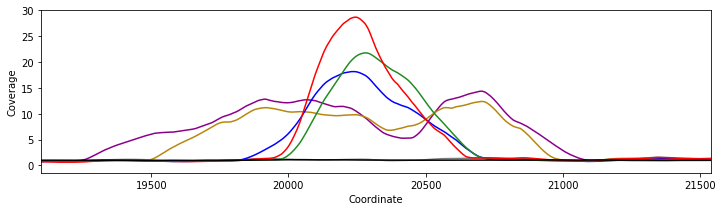

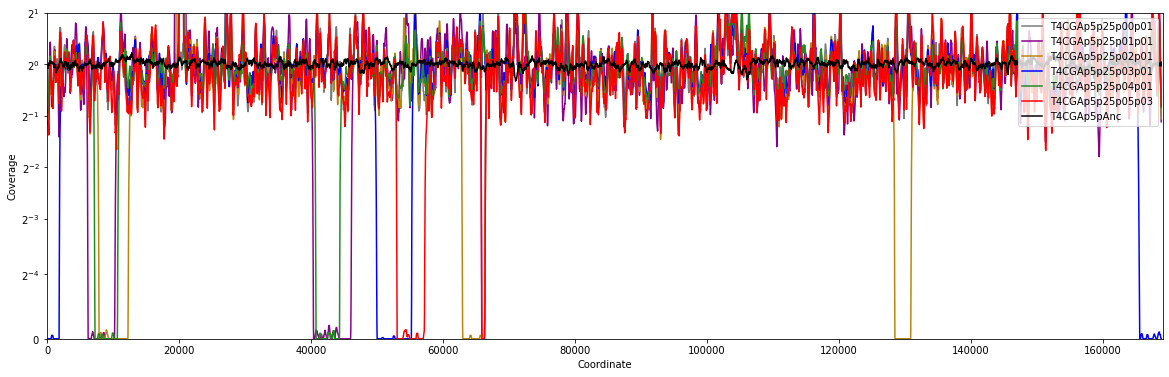

In [3]:
##Plotting coverage as a rolling average over read-size across the reference genome from result of bwa aligner.
# analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")
# sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
#Defined above centrally.
plot_sample_list = raw_sample_list.dropna(subset=['PlottingReference'])
sample_list = raw_sample_list.dropna(subset=['Reference'])

bwa_dir = os.path.join(analysis_working_dir, "bwa")
reference_genomes_dir = os.path.join(analysis_working_dir, "refgenomes")
variant_dir = os.path.join(analysis_working_dir, "variants")

figure_dir = os.path.join(analysis_working_dir, "figures")
if not(os.path.isdir(figure_dir)):
    os.mkdir(figure_dir)

#Intialize a dataframe for each of the reference genomes used here.
refgenome_list = sample_list['PlottingReference'].unique()
#print(refgenome_list)
iter_count = 0
sample_coverage_arrays = {}
for refgenome in refgenome_list:
    #print(refgenome)
    sample_coverage_arrays[refgenome] = pd.DataFrame()

for sample in plot_sample_list['SampleName']:
    #Import the coverage-depth csv.
    coverage_depth_filename = os.path.join(variant_dir, sample+"_bwa_coverage-depth.csv")
    refgenome = plot_sample_list[plot_sample_list['SampleName'] == sample].iloc[0]['PlottingReference']
    if sample_coverage_arrays[refgenome].empty:
        sample_coverage_arrays[refgenome] = pd.read_csv(coverage_depth_filename, sep="\t", names=['RefGenome', 'Coordinate', sample])
        #print(sample_coverage_arrays[refgenome][:5])
        
    else:
        temp_dataframe = pd.DataFrame()
        temp_dataframe = pd.read_csv(coverage_depth_filename, sep="\t", names=['RefGenome', 'Coordinate', sample])
        sample_coverage_arrays[refgenome] = sample_coverage_arrays[refgenome].merge(temp_dataframe, how='left', on=['RefGenome', 'Coordinate']);
        #print(sample_coverage_arrays[refgenome][:5])
    
#Check final coverage-depth dataframes generated per reference genome
for refgenome in refgenome_list:
    print("\t".join(["Size of genome over which coverage is calculated:", refgenome, str(len(sample_coverage_arrays[refgenome]))]))

    
# #Testing rolling average of coverage-depth.
# sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc'].rolling(200).mean()
# sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p05p03p01_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p05p03p01'].rolling(200).mean()

# #Test plot of coverage by coordinate
# fig1 = figure(figsize=(6,10))
# ax1 = subplot(311)
# ax1 = sns.lineplot(x='Coordinate', y='T4CGAp5p05p03p01', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])
# ax1 = sns.lineplot(x='Coordinate', y='T4CGAp5pAnc', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])

# ax2 = subplot(312)
# ax2 = sns.lineplot(x='Coordinate', y='T4CGAp5p05p03p01_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])
# ax2 = sns.lineplot(x='Coordinate', y='T4CGAp5pAnc_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])

# ax3 = subplot(313)
# ax3 = sns.histplot(x='T4CGAp5p05p03p01_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color='red')
# ax3 = sns.histplot(x='T4CGAp5pAnc_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color='black', alpha=0.8)
# ax3.set_yscale('log')

#plot_color_palette = [sns.color_palette("Greys", 4)[2]] + sns.color_palette("deep", 5)[0:] + [matplotlib.colors.to_rgb("Black")]
plot_color_palette = [sns.color_palette("Greys", 4)[2]] + [matplotlib.colors.to_rgb("darkmagenta")] + [matplotlib.colors.to_rgb("darkgoldenrod")] + [matplotlib.colors.to_rgb("blue")] + [matplotlib.colors.to_rgb("forestgreen")] + [matplotlib.colors.to_rgb("red")] + [matplotlib.colors.to_rgb("Black")]

itercount = 0
fig2 = figure(figsize=(12,3))
for sample in plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values:
    ##Narmalize the coverage depth to mean coverage across genome for each sample.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample]/sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].mean()
    ##Making new columns for rolling average mean.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].rolling(250, center=True).mean()
    ax4 = sns.lineplot(x='Coordinate', y=sample+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color=plot_color_palette[itercount])
    itercount += 1
ax4.set_xlim(19098,21539) #The coordinate is restricted to +/- 1kb from the locus of interest dmd-61p4
ax4.set_ylabel("Coverage")
#ax4.set_yscale('symlog', base=2)
#ax4.legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#savefig(os.path.join(figure_dir, "T4CGAp5p05-clones_dmd-61p4_locus-coverage-smoothed_Figure4_211025.pdf"), dpi=300, transparent=True)

itercount = 0
fig3 = figure(figsize=(20,6))
for sample in plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values:
    ##Narmalize the coverage depth to mean coverage across genome for each sample.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample]/sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].mean()
    ##Making new columns for rolling average mean.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].rolling(250, center=True).mean()
    ax5 = sns.lineplot(x='Coordinate', y=sample+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color=plot_color_palette[itercount])
    itercount += 1
ax5.set_ylabel("Coverage")
ax5.set_ylim(0,2)
ax5.set_yscale('symlog', base=2, linthresh=0.1)
ax5.set_xlim(-100,169000)
ax5.legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#savefig(os.path.join(figure_dir, "T4CGAp5p05-clones_coverage_210822.pdf"), dpi=300, transparent=True)

Size of genome over which coverage is calculated:	T4CGAp5pAnc_consensus	168923
['T4CGAp5p25p00p01' 'T4CGAp5p25p01p01' 'T4CGAp5p25p02p01'
 'T4CGAp5p25p03p01' 'T4CGAp5p25p04p01' 'T4CGAp5p25p05p03']


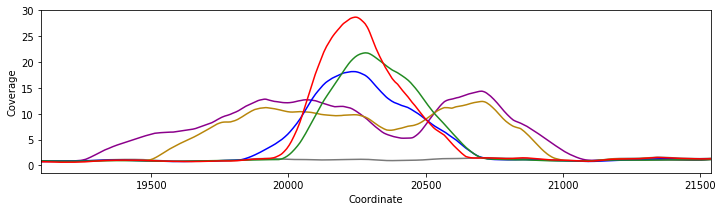

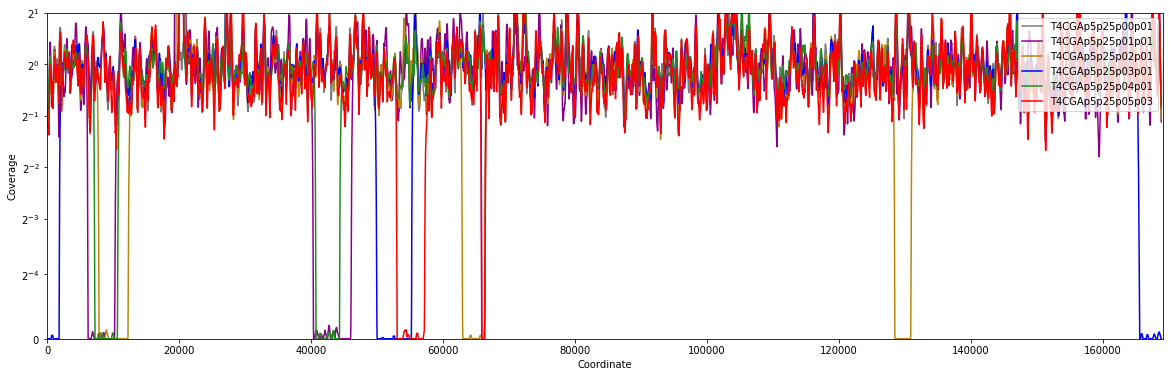

In [3]:
###Repeat of above but realized it is improper to plot the T4CGAp5pAnc sequencing from Lib02 with these results. I am going to change this to only include the 
###T4CGAp5p25p00p01 sample as the control.
##Plotting coverage as a rolling average over read-size across the reference genome from result of bwa aligner.
# analysis_working_dir = os.path.join(illumina_data_dir, "20210315_Phage-gDNA_Lib07_T4CGAp5_MiSeq-Nano_210313")
# sample_list = pd.read_csv(os.path.join(analysis_working_dir, "Lib07_T4Ap5_sample-list.csv"), index_col=None)
#Defined above centrally.
plot_sample_list = raw_sample_list.dropna(subset=['PlottingReference'])
sample_list = raw_sample_list.dropna(subset=['Reference'])

bwa_dir = os.path.join(analysis_working_dir, "bwa")
reference_genomes_dir = os.path.join(analysis_working_dir, "refgenomes")
variant_dir = os.path.join(analysis_working_dir, "variants")

figure_dir = os.path.join(analysis_working_dir, "figures")
if not(os.path.isdir(figure_dir)):
    os.mkdir(figure_dir)

#Intialize a dataframe for each of the reference genomes used here.
refgenome_list = sample_list['PlottingReference'].unique()
#print(refgenome_list)
iter_count = 0
sample_coverage_arrays = {}
for refgenome in refgenome_list:
    #print(refgenome)
    sample_coverage_arrays[refgenome] = pd.DataFrame()

for sample in plot_sample_list['SampleName']:
    #Import the coverage-depth csv.
    coverage_depth_filename = os.path.join(variant_dir, sample+"_bwa_coverage-depth.csv")
    refgenome = plot_sample_list[plot_sample_list['SampleName'] == sample].iloc[0]['PlottingReference']
    if sample_coverage_arrays[refgenome].empty:
        sample_coverage_arrays[refgenome] = pd.read_csv(coverage_depth_filename, sep="\t", names=['RefGenome', 'Coordinate', sample])
        #print(sample_coverage_arrays[refgenome][:5])
        
    else:
        temp_dataframe = pd.DataFrame()
        temp_dataframe = pd.read_csv(coverage_depth_filename, sep="\t", names=['RefGenome', 'Coordinate', sample])
        sample_coverage_arrays[refgenome] = sample_coverage_arrays[refgenome].merge(temp_dataframe, how='left', on=['RefGenome', 'Coordinate']);
        #print(sample_coverage_arrays[refgenome][:5])
    
#Check final coverage-depth dataframes generated per reference genome
for refgenome in refgenome_list:
    print("\t".join(["Size of genome over which coverage is calculated:", refgenome, str(len(sample_coverage_arrays[refgenome]))]))

    
# #Testing rolling average of coverage-depth.
# sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc'].rolling(200).mean()
# sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p05p03p01_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p05p03p01'].rolling(200).mean()

# #Test plot of coverage by coordinate
# fig1 = figure(figsize=(6,10))
# ax1 = subplot(311)
# ax1 = sns.lineplot(x='Coordinate', y='T4CGAp5p05p03p01', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])
# ax1 = sns.lineplot(x='Coordinate', y='T4CGAp5pAnc', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])

# ax2 = subplot(312)
# ax2 = sns.lineplot(x='Coordinate', y='T4CGAp5p05p03p01_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])
# ax2 = sns.lineplot(x='Coordinate', y='T4CGAp5pAnc_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'])

# ax3 = subplot(313)
# ax3 = sns.histplot(x='T4CGAp5p05p03p01_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color='red')
# ax3 = sns.histplot(x='T4CGAp5pAnc_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color='black', alpha=0.8)
# ax3.set_yscale('log')

#plot_color_palette = [sns.color_palette("Greys", 4)[2]] + sns.color_palette("deep", 5)[0:] + [matplotlib.colors.to_rgb("Black")]
#plot_color_palette = [sns.color_palette("Greys", 4)[2]] + [matplotlib.colors.to_rgb("darkmagenta")] + [matplotlib.colors.to_rgb("darkgoldenrod")] + [matplotlib.colors.to_rgb("blue")] + [matplotlib.colors.to_rgb("forestgreen")] + [matplotlib.colors.to_rgb("red")] + [matplotlib.colors.to_rgb("Black")]
plot_color_palette = [sns.color_palette("Greys", 4)[2]] + [matplotlib.colors.to_rgb("darkmagenta")] + [matplotlib.colors.to_rgb("darkgoldenrod")] + [matplotlib.colors.to_rgb("blue")] + [matplotlib.colors.to_rgb("forestgreen")] + [matplotlib.colors.to_rgb("red")]

print(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values[:-1])
#os.sys.exit()

itercount = 0
fig2 = figure(figsize=(12,3))
for sample in plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values[:-1]:
    ##Narmalize the coverage depth to mean coverage across genome for each sample.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample]/sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].mean()
    ##Making new columns for rolling average mean.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].rolling(250, center=True).mean()
    ax4 = sns.lineplot(x='Coordinate', y=sample+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color=plot_color_palette[itercount])
    itercount += 1
ax4.set_xlim(19098,21539) #The coordinate is restricted to +/- 1kb from the locus of interest dmd-61p4
ax4.set_ylabel("Coverage")
#ax4.set_yscale('symlog', base=2)
#ax4.legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#savefig(os.path.join(figure_dir, "T4CGAp5p05-clones_dmd-61p4_locus-coverage-smoothed_Figure4_211229.pdf"), dpi=300, transparent=True)

itercount = 0
fig3 = figure(figsize=(20,6))
for sample in plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values[:-1]:
    ##Narmalize the coverage depth to mean coverage across genome for each sample.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample]/sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].mean()
    ##Making new columns for rolling average mean.
    sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'] = sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].rolling(250, center=True).mean()
    ax5 = sns.lineplot(x='Coordinate', y=sample+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], color=plot_color_palette[itercount])
    itercount += 1
ax5.set_ylabel("Coverage")
ax5.set_ylim(0,2)
ax5.set_yscale('symlog', base=2, linthresh=0.1)
ax5.set_xlim(-100,169000)
ax5.legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#savefig(os.path.join(figure_dir, "T4CGAp5p05-clones_coverage_211229.pdf"), dpi=300, transparent=True)

In [4]:
print(sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p25p05p03_mean'].max())

28.685832758433705


In [7]:
##Code to measure mean coverage across the specific region of the repeat in each sample.
###Import the csv of the repeat region limits.
repeat_region_limits_frame = pd.read_csv(os.path.join(analysis_working_dir, "T4CGAp5p25-clones_repeat-regions.csv"), index_col=None)
repeat_region_limits_frame['coverage_mean'] = float(0)
repeat_region_limits_frame['coverage_std'] = float(0)
repeat_region_limits_frame['coverage_median'] = float(0)
repeat_region_limits_frame['coverage_quantile25'] = float(0)
repeat_region_limits_frame['coverage_quantile75'] = float(0)
repeat_region_limits_frame['coverage_mean_mean'] = float(0)
repeat_region_limits_frame['coverage_mean_median'] = float(0)
repeat_region_limits_frame['coverage_mean_max'] = float(0)

#print(repeat_region_limits_frame)
print(repeat_region_limits_frame['Strain'].unique())
#os.sys.exit()

for index, row in repeat_region_limits_frame.iterrows():
    ###I am going to print the mean of the coverage over the repeat regions
    #print(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[500:525])
    #os.sys.exit()
    sample = row['Strain']
    start_site = row['RepeatStart']
    #print(row['Strain'], "\t", start_site)
    end_site = row['RepeatEnd']
    #print(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].mean())
    #print(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].median())
    #print(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'].iloc[start_site-1:end_site].max())
    #os.sys.exit()
    
    repeat_region_limits_frame.at[index, 'coverage_mean'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].mean())
    repeat_region_limits_frame.at[index, 'coverage_std'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].std())
    repeat_region_limits_frame.at[index, 'coverage_median'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].median())
    repeat_region_limits_frame.at[index, 'coverage_quantile25'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].quantile(0.25))
    repeat_region_limits_frame.at[index, 'coverage_quantile75'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample].iloc[start_site-1:end_site].quantile(0.75))
    repeat_region_limits_frame.at[index, 'coverage_mean_mean'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'].iloc[start_site-1:end_site].mean())
    repeat_region_limits_frame.at[index, 'coverage_mean_median'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'].iloc[start_site-1:end_site].median())
    repeat_region_limits_frame.at[index, 'coverage_mean_max'] = float(sample_coverage_arrays['T4CGAp5pAnc_consensus'][sample+'_mean'].iloc[start_site-1:end_site].max())
    
##Output means.
print(repeat_region_limits_frame)
repeat_region_limits_frame.to_csv(os.path.join(analysis_working_dir, "results", "T4CGAp5p25-clones05_amplification-stats_220401.csv"), sep="\t", index=False)

['T4CGAp5p25p00p01' 'T4CGAp5p25p01p01' 'T4CGAp5p25p02p01'
 'T4CGAp5p25p03p01' 'T4CGAp5p25p04p01' 'T4CGAp5p25p05p03']
             Strain  RepeatStart  RepeatEnd  coverage_mean  coverage_std  \
0  T4CGAp5p25p00p01        19369      20969       1.142578      0.397945   
1  T4CGAp5p25p01p01        19369      20969       9.452545      4.547259   
2  T4CGAp5p25p02p01        19585      20877       9.398094      3.561472   
3  T4CGAp5p25p03p01        19946      20618      12.148992      5.769279   
4  T4CGAp5p25p04p01        20090      20598      16.840930      5.964008   
5  T4CGAp5p25p05p03        20041      20552      19.494420     11.989080   

   coverage_median  coverage_quantile25  coverage_quantile75  \
0         1.083619             0.829564             1.462107   
1         8.113658             6.032951            11.955811   
2         9.045493             6.707738            11.730440   
3        11.341431             8.278588            14.863936   
4        16.980859            

In [17]:
repeat_region_limits_frame

,Strain,RepeatStart,RepeatEnd,coverage_mean,coverage_median,coverage_max
0,T4CGAp5p25p00p01,19369,20969,1.142578,1.083619,1.482888
1,T4CGAp5p25p01p01,19369,20969,9.452545,8.113658,14.359678
2,T4CGAp5p25p02p01,19585,20877,9.398094,9.045493,12.377252
3,T4CGAp5p25p03p01,19946,20618,12.148992,11.341431,18.148936
4,T4CGAp5p25p04p01,20090,20598,16.840930,16.980859,21.775248
5,T4CGAp5p25p05p03,20041,20552,19.494420,16.269641,28.685833


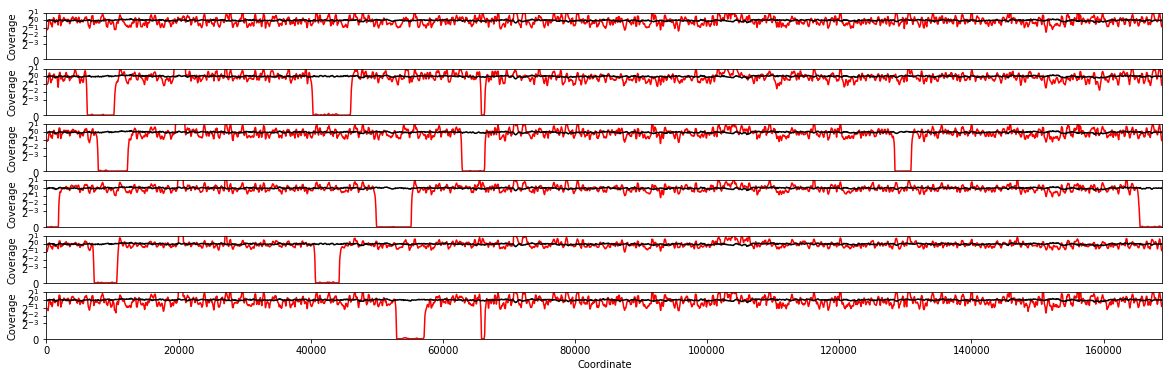

In [48]:
##Trying to plot the coverage maps on separate plots using an array.
plot_sample_list = raw_sample_list.dropna(subset=['PlottingReference'])
sample_list = raw_sample_list.dropna(subset=['Reference'])
fig4, ax_array = plt.subplots(len(sample_list), 1, figsize=(20,6))
plot_reference = plot_sample_list['PlottingReference'].unique()[-1].split("_")[0]
plot_list = sample_list[sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values
# print(plot_list)
# print(plot_list.tolist().index('T4CGAp5p25p00p01'))
# sys.exit()

for sample in plot_list:
    sns.lineplot(x='Coordinate', y=sample+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], ax=ax_array[plot_list.tolist().index(sample)],
                 color='red')
    sns.lineplot(x='Coordinate', y=plot_reference+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], ax=ax_array[plot_list.tolist().index(sample)],
                 color='black')
    #ax_array[plot_list.tolist().index(sample)].set_xlim([-100, 169000])
    ax_array[plot_list.tolist().index(sample)].xaxis.set_visible(False)
    ax_array[plot_list.tolist().index(sample)].set_xlim([0, 168923])
    ax_array[plot_list.tolist().index(sample)].set_ylabel("Coverage")
    ax_array[plot_list.tolist().index(sample)].set_yscale('symlog', base=2, linthresh=0.125)
    ax_array[plot_list.tolist().index(sample)].set_ylim([0, 2])
    #sys.exit()
ax_array[plot_list.tolist().index(sample)].xaxis.set_visible(True)
#ax_array[0].legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#plt.tight_layout()

#savefig(os.path.join(figure_dir, "T4CGAp5p25-clones_separate-coverage-maps_Figure5_211201.pdf"), dpi=300, transparent=True)

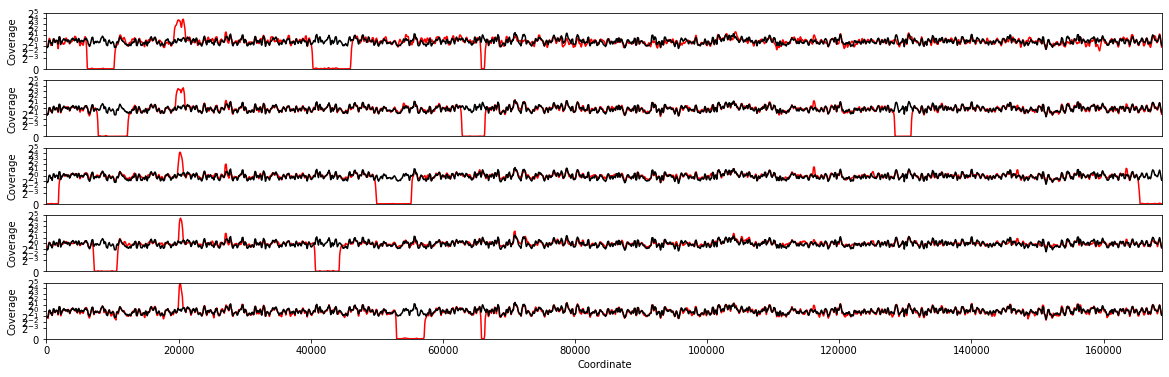

In [10]:
###Modifying to remove the T4CGAp5pAnc sample as the reference, instead I am going to switch to T4CGAp5p25p00p01.
##Trying to plot the coverage maps on separate plots using an array.
plot_sample_list = raw_sample_list.dropna(subset=['PlottingReference'])
sample_list = raw_sample_list.dropna(subset=['Reference'])
fig4, ax_array = plt.subplots(len(sample_list)-1, 1, figsize=(20,6))
plot_reference = plot_sample_list['PlottingReference'].unique()[-1].split("_")[0]
plot_list = sample_list[sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values
# print(plot_list)
# print(plot_list.tolist().index('T4CGAp5p25p00p01'))
# sys.exit()

for sample in plot_list[1:]:
    sns.lineplot(x='Coordinate', y=sample+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], ax=ax_array[plot_list.tolist().index(sample)-1],
                 color='red')
    sns.lineplot(x='Coordinate', y=plot_list[0]+'_mean', data=sample_coverage_arrays['T4CGAp5pAnc_consensus'], ax=ax_array[plot_list.tolist().index(sample)-1],
                 color='black')
    #ax_array[plot_list.tolist().index(sample)].set_xlim([-100, 169000])
    ax_array[plot_list.tolist().index(sample)-1].xaxis.set_visible(False)
    ax_array[plot_list.tolist().index(sample)-1].set_xlim([0, 168923])
    ax_array[plot_list.tolist().index(sample)-1].set_ylabel("Coverage")
    ax_array[plot_list.tolist().index(sample)-1].set_yscale('symlog', base=2, linthresh=0.125)
    ax_array[plot_list.tolist().index(sample)-1].set_ylim([0, 32])
    #sys.exit()
ax_array[plot_list.tolist().index(sample)-1].xaxis.set_visible(True)
#ax_array[0].legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#plt.tight_layout()

#savefig(os.path.join(figure_dir, "T4CGAp5p25-clones_separate-coverage-maps_Figure5_211229.pdf"), dpi=300, transparent=True)

168923


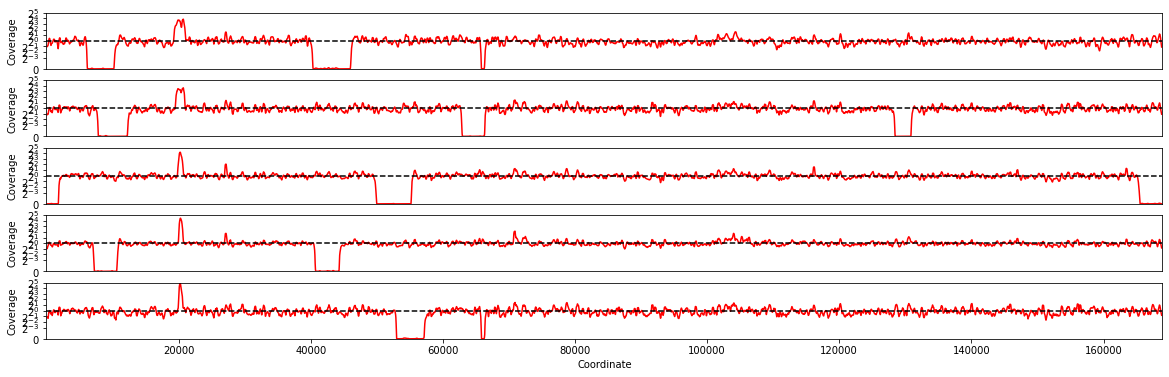

In [4]:
###I need to plot the coverage for the genome compared to coverage 1. The locus coordinates are [0, 168923]
ipIII_locus_frame = pd.read_csv(os.path.join(analysis_working_dir, "T4CGAp5p25-clones_ipIII-locus.csv"), index_col=None)
print(len(sample_coverage_arrays['T4CGAp5pAnc_consensus'].iloc[0:168923]))

ipIII_locus_coverage_arrays = sample_coverage_arrays['T4CGAp5pAnc_consensus'].iloc[0:168923].copy()

plot_sample_list = raw_sample_list.dropna(subset=['PlottingReference'])
sample_list = raw_sample_list.dropna(subset=['Reference'])
fig4, ax_array = plt.subplots(len(sample_list)-1, 1, figsize=(20,6))
plot_reference = plot_sample_list['PlottingReference'].unique()[-1].split("_")[0]
plot_list = sample_list[sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values
# print(plot_list)
# print(plot_list.tolist().index('T4CGAp5p25p00p01'))
# sys.exit()

for sample in plot_list[1:]:
    sns.lineplot(x='Coordinate', y=sample+'_mean', data=ipIII_locus_coverage_arrays, ax=ax_array[plot_list.tolist().index(sample)-1],
                 color='red')
#     sns.lineplot(x='Coordinate', y=plot_list[0]+'_mean', data=ipIII_locus_coverage_arrays, ax=ax_array[plot_list.tolist().index(sample)-1],
#                  color='black')
    kwargs={'color':'black','linestyle':'dashed'}
    ax_array[plot_list.tolist().index(sample)-1].axhline(y=1, xmin=0, xmax=1, **kwargs)
    #ax_array[plot_list.tolist().index(sample)].set_xlim([-100, 169000])
    ax_array[plot_list.tolist().index(sample)-1].xaxis.set_visible(False)
    ax_array[plot_list.tolist().index(sample)-1].set_xlim([1, 168923])
    ax_array[plot_list.tolist().index(sample)-1].set_ylabel("Coverage")
    ax_array[plot_list.tolist().index(sample)-1].set_yscale('symlog', base=2, linthresh=0.125)
    ax_array[plot_list.tolist().index(sample)-1].set_ylim([0, 32])
    #sys.exit()
ax_array[plot_list.tolist().index(sample)-1].xaxis.set_visible(True)
#ax_array[0].legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#plt.tight_layout()

savefig(os.path.join(figure_dir, "T4CGAp5p25-clones_separate-coverage-maps_FigureS5C_220324.pdf"), dpi=300, transparent=True)

1582


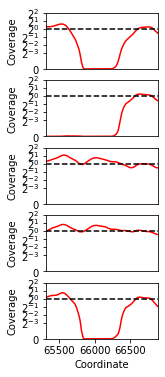

In [61]:
###I need to plot the coverage for the ipIII locus. The locus coordinates are [65316, 66897]
ipIII_locus_frame = pd.read_csv(os.path.join(analysis_working_dir, "T4CGAp5p25-clones_ipIII-locus.csv"), index_col=None)
print(len(sample_coverage_arrays['T4CGAp5pAnc_consensus'].iloc[65315:66897]))

ipIII_locus_coverage_arrays = sample_coverage_arrays['T4CGAp5pAnc_consensus'].iloc[65315:66897].copy()

plot_sample_list = raw_sample_list.dropna(subset=['PlottingReference'])
sample_list = raw_sample_list.dropna(subset=['Reference'])
fig4, ax_array = plt.subplots(len(sample_list)-1, 1, figsize=(2,6))
plot_reference = plot_sample_list['PlottingReference'].unique()[-1].split("_")[0]
plot_list = sample_list[sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values
# print(plot_list)
# print(plot_list.tolist().index('T4CGAp5p25p00p01'))
# sys.exit()

for sample in plot_list[1:]:
    sns.lineplot(x='Coordinate', y=sample+'_mean', data=ipIII_locus_coverage_arrays, ax=ax_array[plot_list.tolist().index(sample)-1],
                 color='red')
#     sns.lineplot(x='Coordinate', y=plot_list[0]+'_mean', data=ipIII_locus_coverage_arrays, ax=ax_array[plot_list.tolist().index(sample)-1],
#                  color='black')
    kwargs={'color':'black','linestyle':'dashed'}
    ax_array[plot_list.tolist().index(sample)-1].axhline(y=1, xmin=0, xmax=1, **kwargs)
    #ax_array[plot_list.tolist().index(sample)].set_xlim([-100, 169000])
    ax_array[plot_list.tolist().index(sample)-1].xaxis.set_visible(False)
    ax_array[plot_list.tolist().index(sample)-1].set_xlim([65316, 66897])
    ax_array[plot_list.tolist().index(sample)-1].set_ylabel("Coverage")
    ax_array[plot_list.tolist().index(sample)-1].set_yscale('symlog', base=2, linthresh=0.125)
    ax_array[plot_list.tolist().index(sample)-1].set_ylim([0, 4])
    #sys.exit()
ax_array[plot_list.tolist().index(sample)-1].xaxis.set_visible(True)
#ax_array[0].legend(plot_sample_list[plot_sample_list['PlottingReference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values, loc='upper right')
#plt.tight_layout()

#savefig(os.path.join(figure_dir, "T4CGAp5p25-clones_ipIII-locus-coverage-maps_Figure6_220102.pdf"), dpi=300, transparent=True)

4128


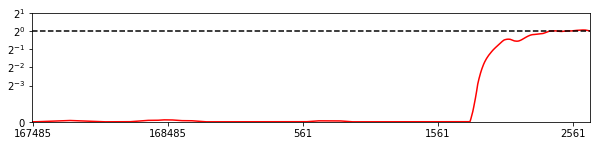

In [60]:
###I am going to plot the region of the rIIA-B locus. [167485-168923] & [1-2689]
rIIAB_coverage_array = sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p25p03p01_mean'].iloc[167484:].values.tolist() + sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p25p03p01_mean'].iloc[:2689].values.tolist()
#print(rIIAB_coverage_array)
print(len(rIIAB_coverage_array))
axes_coordinates = [i for i in range(1,4129)]
genome_coordinates = [i for i in range(167485,168924)] + [i for i in range(1,2690)]
#print(genome_coordinates)
fig5, ax5 = plt.subplots(1, 1, figsize=(10,2))
sns.lineplot(x=axes_coordinates, y=rIIAB_coverage_array, color='red')
kwargs={'color':'black','linestyle':'dashed'}
ax5.axhline(y=1, xmin=0, xmax=1, **kwargs)
ax5.set_yscale('symlog', base=2, linthresh=0.125)
ax5.set_ylim([0, 2])
ax5.set_xlim([0,4129])
ax5.set_xticks([1,1000,2000,3000,4000]);
ax5.set_xticklabels([167485,168485,561,1561,2561]);
#print(rIIAB_coverage_array)

#savefig(os.path.join(figure_dir, "T4CGAp5p25p03p01_rIIAB-locus-coverage-maps_Figure6_220102.pdf"), dpi=300, transparent=True)

In [12]:
sample_list = raw_sample_list.dropna(subset=['Reference'])
sample_list

,SampleName,FileName,Reference,PlottingReference
1,T4CGAp5p25p00p01,210317Lau_D21-2631,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
2,T4CGAp5p25p01p01,210317Lau_D21-2632,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
3,T4CGAp5p25p02p01,210317Lau_D21-2633,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
4,T4CGAp5p25p03p01,210317Lau_D21-2634,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
5,T4CGAp5p25p04p01,210317Lau_D21-2635,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus
6,T4CGAp5p25p05p03,210317Lau_D21-2636,T4CGAp5pAnc_consensus,T4CGAp5pAnc_consensus


[(0.47843137254901963, 0.47843137254901963, 0.47843137254901963), (0.5450980392156862, 0.0, 0.5450980392156862), (0.7215686274509804, 0.5254901960784314, 0.043137254901960784), (0.0, 0.0, 0.5450980392156862), (0.13333333333333333, 0.5450980392156862, 0.13333333333333333), (0.5450980392156862, 0.0, 0.0), (0.0, 0.0, 0.0)]


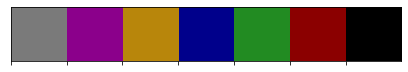

In [2]:
#print(sample_list[sample_list['Reference'] == 'T4CGAp5pAnc_consensus']['SampleName'].sort_values().values)
# print(sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc'].mean())
# print(sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc']/sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5pAnc'].mean())

# fig3 = figure(figsize=(6,6))
# plt.scatter(sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p05p05p02'], sample_coverage_arrays['T4CGAp5pAnc_consensus']['T4CGAp5p05p03p01'])

#test_palette = sns.color_palette("Blues", 6)[2:] + sns.color_palette("Reds", 6)[2:] + [matplotlib.colors.to_rgb("Black")]
#test_palette = [sns.color_palette("Greys", 4)[2]] + sns.color_palette("colorblind", 4)[0:] + [matplotlib.colors.to_rgb("Black")]
#test_palette = [sns.color_palette("Greys", 4)[2]] + sns.color_palette("deep", 5)[0:] + [matplotlib.colors.to_rgb("Black")]
test_palette = [sns.color_palette("Greys", 4)[2]] + [matplotlib.colors.to_rgb("darkmagenta")] + [matplotlib.colors.to_rgb("darkgoldenrod")] + [matplotlib.colors.to_rgb("darkblue")] + [matplotlib.colors.to_rgb("forestgreen")] + [matplotlib.colors.to_rgb("darkred")] + [matplotlib.colors.to_rgb("Black")]
print(test_palette)
sns.palplot(test_palette)

## Testing Binaries
1. fastqc (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/)
    1. fastqc v0.11.9 installed in bio-conda env
1. cutadapt (https://cutadapt.readthedocs.io/en/stable/ OR https://pypi.org/project/cutadapt/)
    1. cutadapt v3.4 for python 3.7.10
2. bwa (https://github.com/lh3/bwa OR https://anaconda.org/bioconda/bwa)
    1. bwa v0.7.17 is installed.
3. samtools (http://www.htslib.org/ OR https://github.com/samtools/samtools)
    1. samtools v1.7 is installed.
4. varscan (http://varscan.sourceforge.net/ OR https://github.com/dkoboldt/varscan)
    1. varscan v2.4.4 installed (v.2.4.3 installed on LLC2) by conda install.
5. GATK (https://github.com/broadinstitute/gatk OR https://gatk.broadinstitute.org/hc/en-us)
    1. GATK v3.8.1 installed locally (v4.1.9.0 installed on LLC2), and can be run as gatk3
6. bcftools (https://samtools.github.io/bcftools/)
    1. bcftools 1.8 installed (1.7.2 installed on LLC2) by conda install.

In [31]:
cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/fastqc -h"
!{cmd}


            FastQC - A high throughput sequence QC analysis tool

SYNOPSIS

	fastqc seqfile1 seqfile2 .. seqfileN

    fastqc [-o output dir] [--(no)extract] [-f fastq|bam|sam] 
           [-c contaminant file] seqfile1 .. seqfileN

DESCRIPTION

    FastQC reads a set of sequence files and produces from each one a quality
    control report consisting of a number of different modules, each one of 
    which will help to identify a different potential type of problem in your
    data.
    
    If no files to process are specified on the command line then the program
    will start as an interactive graphical application.  If files are provided
    on the command line then the program will run with no user interaction
    required.  In this mode it is suitable for inclusion into a standardised
    analysis pipeline.
    
    The options for the program as as follows:
    
    -h --help       Print this help file and exit
    
    -v --version    Print the version of the program and exit

In [27]:
cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/cutadapt --help"
!{cmd}

cutadapt version 3.4

Copyright (C) 2010-2021 Marcel Martin <marcel.martin@scilifelab.se>

cutadapt removes adapter sequences from high-throughput sequencing reads.

Usage:
    cutadapt -a ADAPTER [options] [-o output.fastq] input.fastq

For paired-end reads:
    cutadapt -a ADAPT1 -A ADAPT2 [options] -o out1.fastq -p out2.fastq in1.fastq in2.fastq

Replace "ADAPTER" with the actual sequence of your 3' adapter. IUPAC wildcard
characters are supported. All reads from input.fastq will be written to
output.fastq with the adapter sequence removed. Adapter matching is
error-tolerant. Multiple adapter sequences can be given (use further -a
options), but only the best-matching adapter will be removed.

Input may also be in FASTA format. Compressed input and output is supported and
auto-detected from the file name (.gz, .xz, .bz2). Use the file name '-' for
standard input/output. Without the -o option, output is sent to standard output.

Citation:

Marcel Martin. Cutadapt removes adapter seque

In [1]:
cmd = "bwa"
!{cmd}


Program: bwa (alignment via Burrows-Wheeler transformation)
Version: 0.7.17-r1188
Contact: Heng Li <lh3@sanger.ac.uk>

Usage:   bwa <command> [options]

Command: index         index sequences in the FASTA format
         mem           BWA-MEM algorithm
         fastmap       identify super-maximal exact matches
         pemerge       merge overlapping paired ends (EXPERIMENTAL)
         aln           gapped/ungapped alignment
         samse         generate alignment (single ended)
         sampe         generate alignment (paired ended)
         bwasw         BWA-SW for long queries

         shm           manage indices in shared memory
         fa2pac        convert FASTA to PAC format
         pac2bwt       generate BWT from PAC
         pac2bwtgen    alternative algorithm for generating BWT
         bwtupdate     update .bwt to the new format
         bwt2sa        generate SA from BWT and Occ

Note: To use BWA, you need to first index the genome with `bwa index'.
      There are

In [2]:
cmd = "samtools --help"
!{cmd}


Program: samtools (Tools for alignments in the SAM format)
Version: 1.7 (using htslib 1.7-2)

Usage:   samtools <command> [options]

Commands:
  -- Indexing
     dict           create a sequence dictionary file
     faidx          index/extract FASTA
     index          index alignment

  -- Editing
     calmd          recalculate MD/NM tags and '=' bases
     fixmate        fix mate information
     reheader       replace BAM header
     targetcut      cut fosmid regions (for fosmid pool only)
     addreplacerg   adds or replaces RG tags
     markdup        mark duplicates

  -- File operations
     collate        shuffle and group alignments by name
     cat            concatenate BAMs
     merge          merge sorted alignments
     mpileup        multi-way pileup
     sort           sort alignment file
     split          splits a file by read group
     quickcheck     quickly check if SAM/BAM/CRAM file appears intact
     fastq          converts a BAM to a FASTQ
     fasta       

In [6]:
cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/varscan -h"
!{cmd}

Command not recognized
VarScan v2.4.4

***NON-COMMERCIAL VERSION***

USAGE: java -jar VarScan.jar [COMMAND] [OPTIONS] 

COMMANDS:
	pileup2snp		Identify SNPs from a pileup file
	pileup2indel		Identify indels a pileup file
	pileup2cns		Call consensus and variants from a pileup file
	mpileup2snp		Identify SNPs from an mpileup file
	mpileup2indel		Identify indels an mpileup file
	mpileup2cns		Call consensus and variants from an mpileup file

	somatic			Call germline/somatic variants from tumor-normal pileups
	copynumber			Determine relative tumor copy number from tumor-normal pileups
	readcounts		Obtain read counts for a list of variants from a pileup file

	filter			Filter SNPs by coverage, frequency, p-value, etc.
	somaticFilter		Filter somatic variants for clusters/indels
	fpfilter		Apply the false-positive filter

	processSomatic		Isolate Germline/LOH/Somatic calls from output
	copyCaller		GC-adjust and process copy number changes from VarScan copynumber output
	compare			Compare two l

In [8]:
cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/gatk3 -h"
!{cmd}

--------------------------------------------------------------------------------------
The Genome Analysis Toolkit (GATK) v3.8-1-0-gf15c1c3ef, Compiled 2018/02/19 05:43:50
Copyright (c) 2010-2016 The Broad Institute
For support and documentation go to https://software.broadinstitute.org/gatk
[Sat Jul 31 15:03:53 PDT 2021] Executing on Linux 5.4.72-microsoft-standard-WSL2 amd64
OpenJDK 64-Bit Server VM 1.8.0_282-b08
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
usage: java -jar GenomeAnalysisTK.jar -T <analysis_type> [-args <arg_file>] [-I <input_file>] [--showFullBamList] [-rbs 
       <read_buffer_size>] [-rf <read_filter>] [-drf <disable_read_filter>] [-L <intervals>] [-XL <excludeIntervals>] [-isr 
       <interval_set_rule>] [-im <interval_merging>] [-ip <interval_padding>] [-R <reference_sequence>] [-ndrs] [-maxRuntime 
       <maxRuntime>] [-maxRuntimeUn

In [10]:
cmd = "/home/ssrikant/anaconda3/envs/bio-conda/bin/bcftools -h"
!{cmd}


Program: bcftools (Tools for variant calling and manipulating VCFs and BCFs)
Version: 1.8 (using htslib 1.8)

Usage:   bcftools [--version|--version-only] [--help] <command> <argument>

Commands:

 -- Indexing
    index        index VCF/BCF files

 -- VCF/BCF manipulation
    annotate     annotate and edit VCF/BCF files
    concat       concatenate VCF/BCF files from the same set of samples
    convert      convert VCF/BCF files to different formats and back
    isec         intersections of VCF/BCF files
    merge        merge VCF/BCF files files from non-overlapping sample sets
    norm         left-align and normalize indels
    plugin       user-defined plugins
    query        transform VCF/BCF into user-defined formats
    reheader     modify VCF/BCF header, change sample names
    sort         sort VCF/BCF file
    view         VCF/BCF conversion, view, subset and filter VCF/BCF files

 -- VCF/BCF analysis
    call         SNP/indel calling
    consensus    create consensus seq

In [14]:
cmd = vcfutils_cmd+" "
!{cmd}


Usage:   vcfutils.pl <command> [<arguments>]

Command: subsam       get a subset of samples
         listsam      list the samples
         fillac       fill the allele count field
         qstats       SNP stats stratified by QUAL

         hapmap2vcf   convert the hapmap format to VCF
         ucscsnp2vcf  convert UCSC SNP SQL dump to VCF

         varFilter    filtering short variants (*)
         vcf2fq       VCF->fastq (**)

Notes: Commands with description endting with (*) may need bcftools
       specific annotations.



### Command line alignment run on LLC2.
run on 20210113 on T4CGAp5p15p03p01 sample from SS-Lib-03 (sample ID: 'D20-261201-4742L/201112Lau_D20-261201_{1,2}\_sequence.fastq.gz', paired end reads) against T4CGAp5pAnc_consensus.fasta. Ideally I will make the consensus de novo from the SS-Lib02 sample (sampleID: 'bmc_raw/201102Lau_D20-252015_{1,2}_sequence.fastq').